In [ ]:

# # Task 3: A/B Hypothesis Testing
# ## AlphaCare Insurance Solutions
# 
# **Objective:** Statistically validate or reject key hypotheses about risk drivers
# 
# ### Hypotheses to Test:
# 1. H₀: There are no risk differences across provinces
# 2. H₀: There are no risk differences between zip codes  
# 3. H₀: There is no significant margin (profit) difference between zip codes
# 4. H₀: There is no significant risk difference between Women and Men
# 
# **Metrics:**
# - Risk = Loss Ratio (TotalClaims / TotalPremium)
# - Margin = TotalPremium - TotalClaims
# - Claim Frequency = Policies with claims / Total policies

# %%
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import power
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# %%
# Load cleaned data from Task 1
print("Loading data...")
df = pd.read_csv('../data/processed/cleaned_insurance_data.csv')

print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
display(df.head())

Loading data...
Data shape: (1000098, 57)
Columns: 57

First few rows:


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,VehicleAge,PremiumToSumInsuredRatio,HasClaim,TransactionYear,TransactionMonthNum
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,11,2192.982456,0,2015,3
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,11,2192.982456,0,2015,5
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,11,0.000000,0,2015,7
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,11,0.004299,0,2015,5
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,11,0.000000,0,2015,7


In [3]:

# ## 1. Define Key Metrics and Helper Functions

# %%
def calculate_risk_metrics(df):
    """
    Calculate risk metrics for A/B testing
    """
    df = df.copy()
    
    # Calculate Loss Ratio (risk metric)
    df['LossRatio'] = (df['TotalClaims'] / df['TotalPremium']) * 100
    
    # Calculate Margin (profit metric)
    df['Margin'] = df['TotalPremium'] - df['TotalClaims']
    
    # Calculate Profit Margin (%)
    df['ProfitMargin'] = (df['Margin'] / df['TotalPremium']) * 100
    
    # Create claim flag
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
    
    return df

def prepare_test_data(df, group_col, metric_col, min_group_size=30):
    """
    Prepare data for A/B testing
    """
    # Calculate group statistics
    group_stats = df.groupby(group_col)[metric_col].agg(['count', 'mean', 'std', 'sem'])
    
    # Filter groups with sufficient data
    valid_groups = group_stats[group_stats['count'] >= min_group_size].index.tolist()
    
    if len(valid_groups) < 2:
        print(f"Warning: Only {len(valid_groups)} groups have sufficient data (min {min_group_size} samples)")
        return None, None
    
    # Filter data for valid groups
    filtered_df = df[df[group_col].isin(valid_groups)].copy()
    
    # Create list of series for each group
    groups_data = []
    for group in valid_groups:
        group_data = filtered_df[filtered_df[group_col] == group][metric_col].dropna()
        if len(group_data) > 0:
            groups_data.append(group_data)
    
    return filtered_df, groups_data

def perform_ab_test(df, group_col, metric_col, test_type='anova', 
                   alpha=0.05, min_group_size=30):
    """
    Perform A/B test between multiple groups
    """
    print(f"\n{'='*60}")
    print(f"A/B TEST: {metric_col} by {group_col}")
    print(f"{'='*60}")
    
    # Prepare data
    filtered_df, groups_data = prepare_test_data(df, group_col, metric_col, min_group_size)
    
    if filtered_df is None:
        print("Insufficient data for testing")
        return None
    
    # Calculate basic statistics
    print(f"\nGroup Statistics:")
    stats_df = filtered_df.groupby(group_col)[metric_col].agg([
        'count', 'mean', 'std', 'min', 'max', 'median'
    ]).round(2)
    display(stats_df)
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Box plot
    filtered_df.boxplot(column=metric_col, by=group_col, ax=axes[0])
    axes[0].set_title(f'Distribution of {metric_col} by {group_col}')
    axes[0].set_xlabel(group_col)
    axes[0].set_ylabel(metric_col)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Bar plot with confidence intervals
    group_means = filtered_df.groupby(group_col)[metric_col].mean()
    group_stds = filtered_df.groupby(group_col)[metric_col].std()
    group_counts = filtered_df.groupby(group_col)[metric_col].count()
    
    # Calculate 95% confidence intervals
    confidence_intervals = 1.96 * (group_stds / np.sqrt(group_counts))
    
    bars = axes[1].bar(range(len(group_means)), group_means.values, 
                       yerr=confidence_intervals.values, 
                       capsize=5, alpha=0.7, edgecolor='black')
    axes[1].set_title(f'Mean {metric_col} by {group_col} with 95% CI')
    axes[1].set_xlabel(group_col)
    axes[1].set_ylabel(f'Mean {metric_col}')
    axes[1].set_xticks(range(len(group_means)))
    axes[1].set_xticklabels(group_means.index, rotation=45, ha='right')
    
    # Add value labels
    for bar, mean in zip(bars, group_means.values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, height,
                    f'{mean:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Perform statistical test
    if test_type == 'anova':
        print("\nPerforming ANOVA Test:")
        print("-" * 40)
        
        # One-way ANOVA
        f_stat, p_value = stats.f_oneway(*groups_data)
        
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        
        if p_value < alpha:
            print(f"✅ REJECT null hypothesis (p < {alpha})")
            print(f"   There ARE significant differences in {metric_col} across {group_col}")
            
            # Perform post-hoc Tukey test if ANOVA is significant
            print("\nPerforming Tukey HSD Post-hoc Test:")
            print("-" * 40)
            
            # Prepare data for Tukey
            tukey_data = pd.DataFrame({
                'value': pd.concat(groups_data, ignore_index=True),
                'group': np.repeat(stats_df.index.tolist(), [len(g) for g in groups_data])
            })
            
            tukey_result = pairwise_tukeyhsd(
                endog=tukey_data['value'],
                groups=tukey_data['group'],
                alpha=alpha
            )
            
            print(tukey_result)
            
            # Visualize Tukey results
            fig, ax = plt.subplots(figsize=(10, 6))
            tukey_result.plot_simultaneous(ax=ax)
            plt.title(f'Tukey HSD Test: {metric_col} by {group_col}')
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"✅ FAIL TO REJECT null hypothesis (p ≥ {alpha})")
            print(f"   There are NO significant differences in {metric_col} across {group_col}")
        
        return {
            'test_type': 'anova',
            'f_statistic': f_stat,
            'p_value': p_value,
            'reject_null': p_value < alpha,
            'alpha': alpha,
            'groups': stats_df.index.tolist(),
            'group_stats': stats_df.to_dict()
        }
    
    elif test_type == 't_test':
        print("\nPerforming Independent T-Test:")
        print("-" * 40)
        
        if len(groups_data) != 2:
            print("T-test requires exactly 2 groups")
            return None
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(groups_data[0], groups_data[1], equal_var=False)
        
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        
        # Calculate effect size (Cohen's d)
        mean_diff = groups_data[1].mean() - groups_data[0].mean()
        pooled_std = np.sqrt((groups_data[0].std()**2 + groups_data[1].std()**2) / 2)
        cohens_d = mean_diff / pooled_std
        
        print(f"Cohen's d (effect size): {cohens_d:.3f}")
        print(f"Mean difference: {mean_diff:.3f}")
        
        if p_value < alpha:
            print(f"✅ REJECT null hypothesis (p < {alpha})")
            print(f"   There IS a significant difference in {metric_col} between groups")
        else:
            print(f"✅ FAIL TO REJECT null hypothesis (p ≥ {alpha})")
            print(f"   There is NO significant difference in {metric_col} between groups")
        
        return {
            'test_type': 't_test',
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'mean_difference': mean_diff,
            'reject_null': p_value < alpha,
            'alpha': alpha
        }
    
    elif test_type == 'kruskal':
        print("\nPerforming Kruskal-Wallis Test (non-parametric ANOVA):")
        print("-" * 40)
        
        # Kruskal-Wallis H-test
        h_stat, p_value = stats.kruskal(*groups_data)
        
        print(f"H-statistic: {h_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        
        if p_value < alpha:
            print(f"✅ REJECT null hypothesis (p < {alpha})")
            print(f"   There ARE significant differences in {metric_col} across {group_col}")
        else:
            print(f"✅ FAIL TO REJECT null hypothesis (p ≥ {alpha})")
            print(f"   There are NO significant differences in {metric_col} across {group_col}")
        
        return {
            'test_type': 'kruskal',
            'h_statistic': h_stat,
            'p_value': p_value,
            'reject_null': p_value < alpha,
            'alpha': alpha
        }

# %%
# Calculate risk metrics
df = calculate_risk_metrics(df)

print("Data with calculated metrics:")
print(f"Total policies: {len(df):,}")
print(f"Policies with claims: {df['HasClaim'].sum():,} ({df['HasClaim'].mean()*100:.1f}%)")
print(f"Average Loss Ratio: {df['LossRatio'].mean():.2f}%")
print(f"Average Margin: R {df['Margin'].mean():,.2f}")

Data with calculated metrics:
Total policies: 1,000,098
Policies with claims: 0 (0.0%)
Average Loss Ratio: -inf%
Average Margin: R 60.04


HYPOTHESIS 1: RISK DIFFERENCES ACROSS PROVINCES

A/B TEST: LossRatio by Province

Group Statistics:


,count,mean,std,min,max,median
Province,,,,,,
Eastern Cape,19698,0.00,0.00,0.00,0.0,0.0
Free State,5932,0.00,0.00,0.00,0.0,0.0
Gauteng,240804,-inf,NaN,-inf,0.0,0.0
KwaZulu-Natal,112142,0.00,0.00,0.00,0.0,0.0
Limpopo,18009,0.00,0.00,0.00,0.0,0.0
Mpumalanga,31665,-inf,NaN,-inf,0.0,0.0
North West,89799,0.00,0.00,0.00,0.0,0.0
Northern Cape,3643,0.00,0.00,0.00,0.0,0.0
Western Cape,96775,-0.01,3.21,-997.37,0.0,0.0


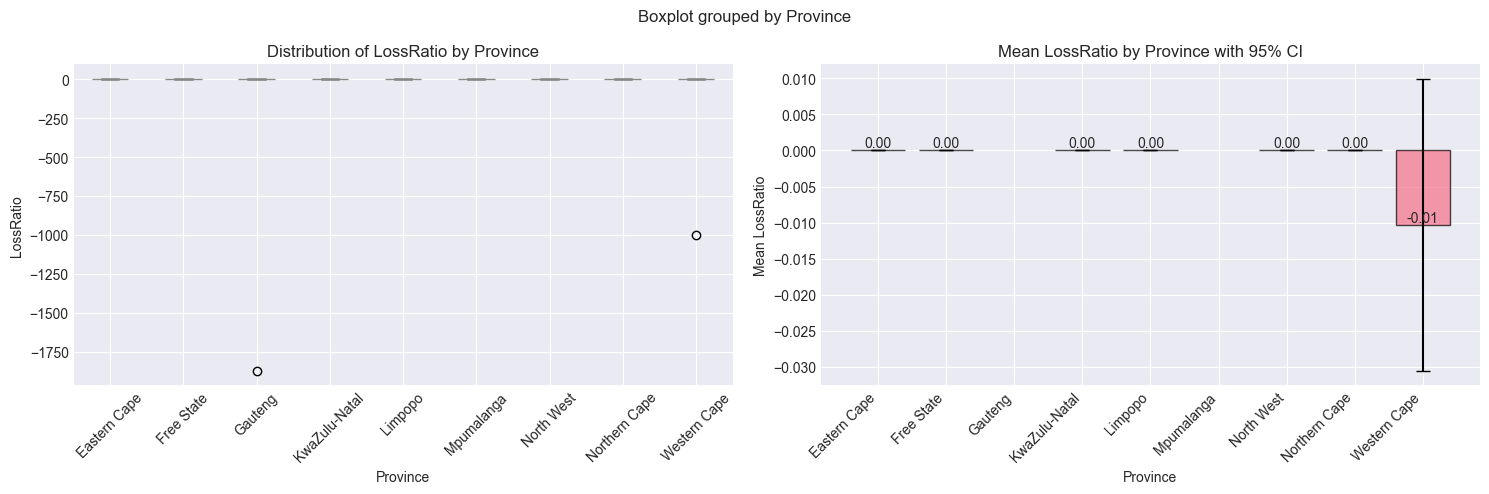


Performing ANOVA Test:
----------------------------------------
F-statistic: nan
P-value: nan
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There are NO significant differences in LossRatio across Province

CLAIM FREQUENCY BY PROVINCE

Claim Frequency by Province:


,TotalPolicies,ClaimsCount,ClaimFrequency
Province,,,
Eastern Cape,30336,0,0.0
Free State,8099,0,0.0
Gauteng,393865,0,0.0
KwaZulu-Natal,169781,0,0.0
Limpopo,24836,0,0.0
Mpumalanga,52718,0,0.0
North West,143287,0,0.0
Northern Cape,6380,0,0.0
Western Cape,170796,0,0.0


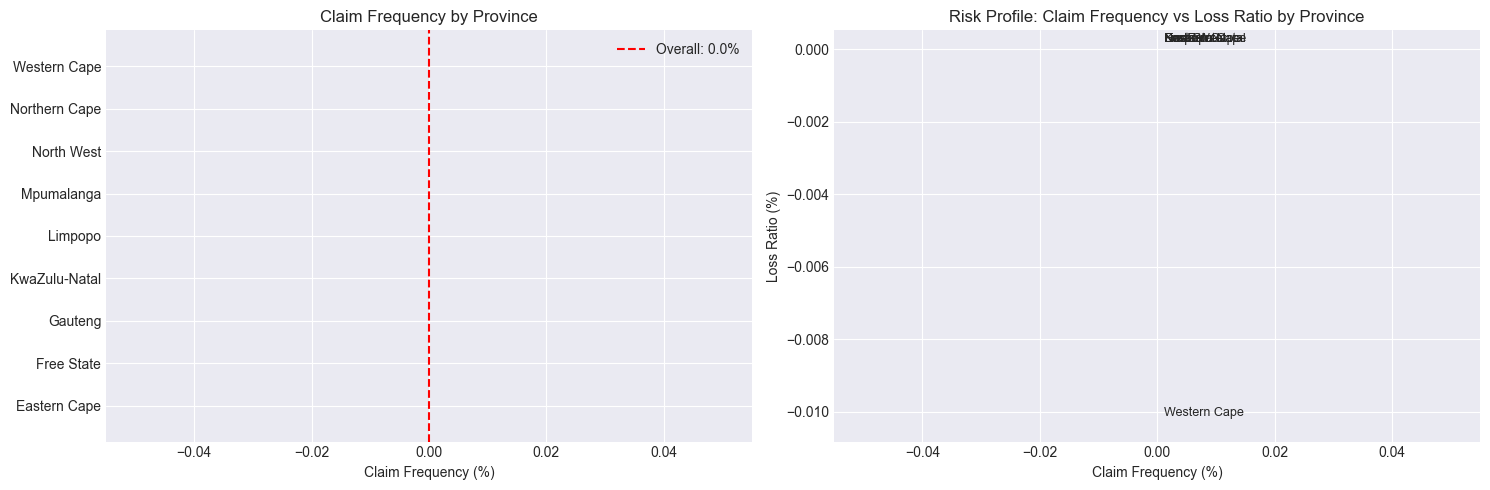


CHI-SQUARE TEST FOR CLAIM FREQUENCY
Contingency Table:


HasClaim,0
Province,
Eastern Cape,30336
Free State,8099
Gauteng,393865
KwaZulu-Natal,169781
Limpopo,24836
Mpumalanga,52718
North West,143287
Northern Cape,6380
Western Cape,170796



Chi-square statistic: 0.0000
P-value: 1.000000
Degrees of freedom: 0
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There are NO significant differences in claim frequency across provinces


In [4]:

# ## Hypothesis 1: Risk Differences Across Provinces
# 
# **Null Hypothesis (H₀):** There are no risk differences across provinces
# 
# **Alternative Hypothesis (H₁):** There ARE risk differences across provinces
# 
# **Test:** One-way ANOVA (for multiple groups)

# %%
print("="*80)
print("HYPOTHESIS 1: RISK DIFFERENCES ACROSS PROVINCES")
print("="*80)

# Test 1.1: Loss Ratio by Province (Risk Metric)
result1 = perform_ab_test(
    df=df,
    group_col='Province',
    metric_col='LossRatio',
    test_type='anova',
    alpha=0.05,
    min_group_size=50
)

# Test 1.2: Claim Frequency by Province
print("\n" + "="*80)
print("CLAIM FREQUENCY BY PROVINCE")
print("="*80)

# Calculate claim frequency by province
province_claims = df.groupby('Province').agg({
    'HasClaim': ['count', 'sum']
}).round(2)

province_claims.columns = ['TotalPolicies', 'ClaimsCount']
province_claims['ClaimFrequency'] = (province_claims['ClaimsCount'] / province_claims['TotalPolicies']) * 100

print("\nClaim Frequency by Province:")
display(province_claims.sort_values('ClaimFrequency', ascending=False))

# Visualize claim frequency
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
sorted_provinces = province_claims.sort_values('ClaimFrequency', ascending=False)
axes[0].barh(sorted_provinces.index, sorted_provinces['ClaimFrequency'])
axes[0].set_xlabel('Claim Frequency (%)')
axes[0].set_title('Claim Frequency by Province')
axes[0].axvline(x=df['HasClaim'].mean()*100, color='red', linestyle='--', 
                label=f'Overall: {df["HasClaim"].mean()*100:.1f}%')
axes[0].legend()

# Scatter plot: Claim Frequency vs Loss Ratio
province_stats = df.groupby('Province').agg({
    'LossRatio': 'mean',
    'HasClaim': 'mean'
}).reset_index()
province_stats['ClaimFrequency'] = province_stats['HasClaim'] * 100

scatter = axes[1].scatter(
    province_stats['ClaimFrequency'],
    province_stats['LossRatio'],
    s=province_stats['LossRatio']*10,  # Size by loss ratio
    alpha=0.7,
    edgecolors='black'
)

axes[1].set_xlabel('Claim Frequency (%)')
axes[1].set_ylabel('Loss Ratio (%)')
axes[1].set_title('Risk Profile: Claim Frequency vs Loss Ratio by Province')

# Add labels for top provinces
for idx, row in province_stats.iterrows():
    axes[1].annotate(
        row['Province'],
        (row['ClaimFrequency'], row['LossRatio']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Statistical test for claim frequency (Chi-square)
print("\n" + "="*80)
print("CHI-SQUARE TEST FOR CLAIM FREQUENCY")
print("="*80)

# Create contingency table
contingency_table = pd.crosstab(df['Province'], df['HasClaim'])
print("Contingency Table:")
display(contingency_table)

# Perform chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("✅ REJECT null hypothesis (p < 0.05)")
    print("   There ARE significant differences in claim frequency across provinces")
else:
    print("✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)")
    print("   There are NO significant differences in claim frequency across provinces")

HYPOTHESIS 2: RISK DIFFERENCES BETWEEN ZIP CODES
Analyzing top 10 zip codes by policy count
Sample size: 312,322 policies

A/B TEST: LossRatio by PostalCode

Group Statistics:


,count,mean,std,min,max,median
PostalCode,,,,,,
122,27898,0.0,0.0,0.0,0.0,0.0
299,16731,0.0,0.0,0.0,0.0,0.0
458,8392,0.0,0.0,0.0,0.0,0.0
470,7052,0.0,0.0,0.0,0.0,0.0
2000,90944,0.0,0.0,0.0,0.0,0.0
2196,7277,0.0,0.0,0.0,0.0,0.0
7100,5906,0.0,0.0,0.0,0.0,0.0
7405,10731,0.0,0.0,0.0,0.0,0.0
7784,13563,0.0,0.0,0.0,0.0,0.0


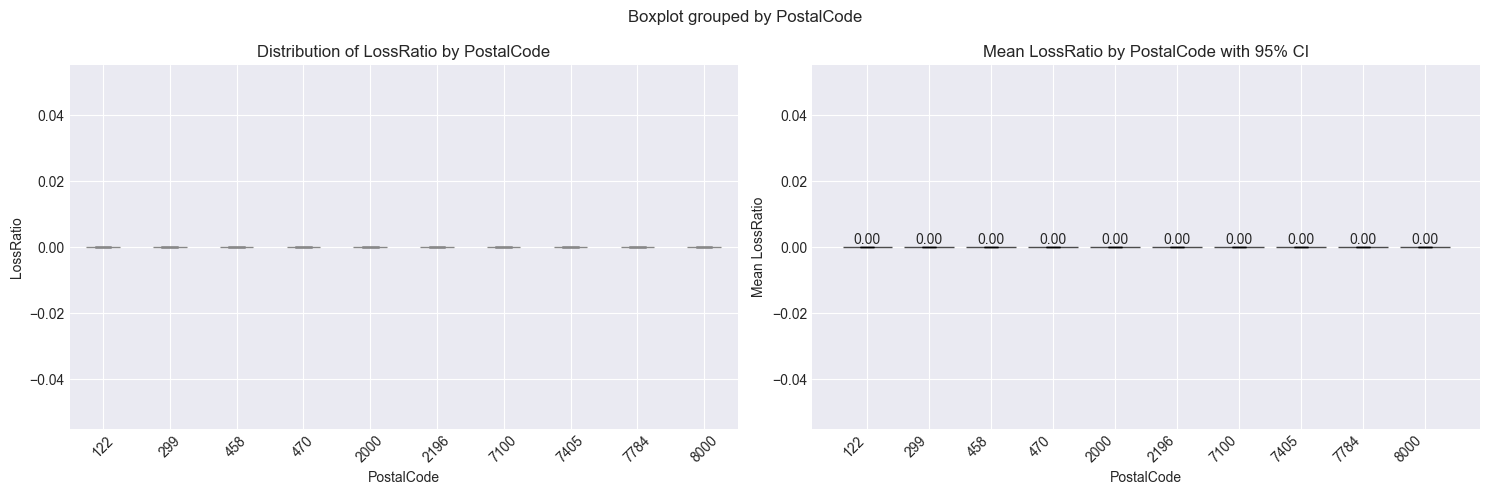


Performing ANOVA Test:
----------------------------------------
F-statistic: nan
P-value: nan
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There are NO significant differences in LossRatio across PostalCode

GEOGRAPHIC RISK ANALYSIS BY POSTAL CODE

Top 10 Highest Risk Zip Codes:


,TotalPremium,TotalClaims,PolicyCount,HasClaim,LossRatio,ClaimFrequency,AvgPremium
PostalCode,,,,,,,
9870,17703.244175,0.0,220,0,0.0,0.0,80.469292
1,270547.403525,0.0,5341,0,0.0,0.0,50.654822
2,59373.501417,0.0,1488,0,0.0,0.0,39.901547
4,8178.524662,0.0,77,0,0.0,0.0,106.214606
5,24661.450526,0.0,400,0,0.0,0.0,61.653626
9459,10712.701304,0.0,90,0,0.0,0.0,119.030014
9447,5339.097596,0.0,90,0,0.0,0.0,59.323307
9445,8532.856825,0.0,80,0,0.0,0.0,106.660710
9431,17793.711392,0.0,277,0,0.0,0.0,64.237225



Top 10 Lowest Risk Zip Codes:


,TotalPremium,TotalClaims,PolicyCount,HasClaim,LossRatio,ClaimFrequency,AvgPremium
PostalCode,,,,,,,
4148,0.0,0.0,64,0,NaN,0.0,0.0
4184,0.0,0.0,56,0,NaN,0.0,0.0
4810,0.0,0.0,48,0,NaN,0.0,0.0
5200,0.0,0.0,110,0,NaN,0.0,0.0
5455,0.0,0.0,80,0,NaN,0.0,0.0
6570,0.0,0.0,288,0,NaN,0.0,0.0
6840,0.0,0.0,216,0,NaN,0.0,0.0
8149,0.0,0.0,297,0,NaN,0.0,0.0
8460,0.0,0.0,72,0,NaN,0.0,0.0


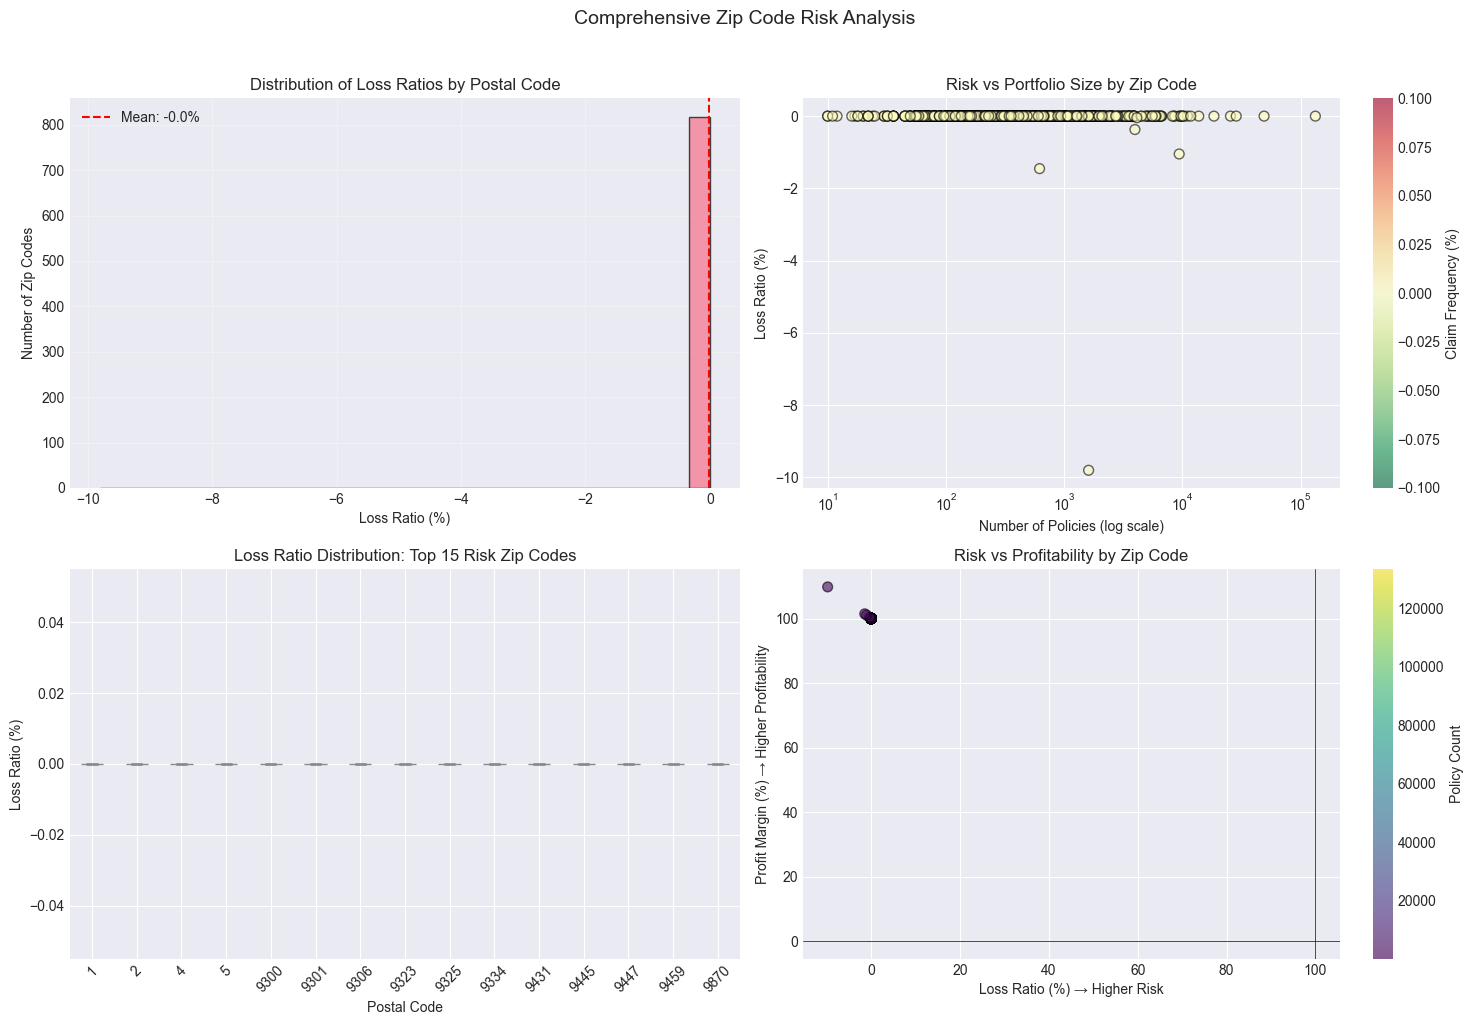

In [5]:

# ## Hypothesis 2: Risk Differences Between Zip Codes
# 
# **Null Hypothesis (H₀):** There are no risk differences between zip codes
# 
# **Test:** ANOVA for top N zip codes by policy count

# %%
print("="*80)
print("HYPOTHESIS 2: RISK DIFFERENCES BETWEEN ZIP CODES")
print("="*80)

# Get top 10 zip codes by policy count
top_zipcodes = df['PostalCode'].value_counts().head(10).index.tolist()
df_top_zips = df[df['PostalCode'].isin(top_zipcodes)].copy()

print(f"Analyzing top {len(top_zipcodes)} zip codes by policy count")
print(f"Sample size: {len(df_top_zips):,} policies")

# Test 2.1: Loss Ratio by Zip Code
result2 = perform_ab_test(
    df=df_top_zips,
    group_col='PostalCode',
    metric_col='LossRatio',
    test_type='anova',
    alpha=0.05,
    min_group_size=20
)

# Test 2.2: Geographic risk heatmap
print("\n" + "="*80)
print("GEOGRAPHIC RISK ANALYSIS BY POSTAL CODE")
print("="*80)

# Calculate risk metrics by postal code
zip_risk = df.groupby('PostalCode').agg({
    'TotalPremium': 'sum',
    'TotalClaims': 'sum',
    'PolicyID': 'count',
    'HasClaim': 'sum'
}).rename(columns={'PolicyID': 'PolicyCount'})

zip_risk['LossRatio'] = (zip_risk['TotalClaims'] / zip_risk['TotalPremium']) * 100
zip_risk['ClaimFrequency'] = (zip_risk['HasClaim'] / zip_risk['PolicyCount']) * 100
zip_risk['AvgPremium'] = zip_risk['TotalPremium'] / zip_risk['PolicyCount']

# Filter zip codes with sufficient data
zip_risk = zip_risk[zip_risk['PolicyCount'] >= 10].sort_values('LossRatio', ascending=False)

print("\nTop 10 Highest Risk Zip Codes:")
display(zip_risk.head(10))

print("\nTop 10 Lowest Risk Zip Codes:")
display(zip_risk.tail(10))

# Visualize distribution of risk by zip code
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of Loss Ratios
axes[0, 0].hist(zip_risk['LossRatio'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=zip_risk['LossRatio'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {zip_risk["LossRatio"].mean():.1f}%')
axes[0, 0].set_xlabel('Loss Ratio (%)')
axes[0, 0].set_ylabel('Number of Zip Codes')
axes[0, 0].set_title('Distribution of Loss Ratios by Postal Code')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Scatter: Policy Count vs Loss Ratio
scatter1 = axes[0, 1].scatter(
    zip_risk['PolicyCount'],
    zip_risk['LossRatio'],
    c=zip_risk['ClaimFrequency'],
    cmap='RdYlGn_r',
    alpha=0.6,
    edgecolors='black',
    s=50
)
axes[0, 1].set_xlabel('Number of Policies (log scale)')
axes[0, 1].set_ylabel('Loss Ratio (%)')
axes[0, 1].set_title('Risk vs Portfolio Size by Zip Code')
axes[0, 1].set_xscale('log')
plt.colorbar(scatter1, ax=axes[0, 1], label='Claim Frequency (%)')

# Box plot of top 15 zip codes
top_15_zips = zip_risk.head(15).index.tolist()
df_top_15 = df[df['PostalCode'].isin(top_15_zips)]
df_top_15.boxplot(column='LossRatio', by='PostalCode', ax=axes[1, 0])
axes[1, 0].set_title('Loss Ratio Distribution: Top 15 Risk Zip Codes')
axes[1, 0].set_xlabel('Postal Code')
axes[1, 0].set_ylabel('Loss Ratio (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Risk vs Profitability
zip_risk['ProfitMargin'] = ((zip_risk['TotalPremium'] - zip_risk['TotalClaims']) / zip_risk['TotalPremium']) * 100
scatter2 = axes[1, 1].scatter(
    zip_risk['LossRatio'],
    zip_risk['ProfitMargin'],
    c=zip_risk['PolicyCount'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    s=50
)
axes[1, 1].set_xlabel('Loss Ratio (%) → Higher Risk')
axes[1, 1].set_ylabel('Profit Margin (%) → Higher Profitability')
axes[1, 1].set_title('Risk vs Profitability by Zip Code')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axvline(x=100, color='black', linestyle='-', linewidth=0.5)
plt.colorbar(scatter2, ax=axes[1, 1], label='Policy Count')

plt.suptitle('Comprehensive Zip Code Risk Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

HYPOTHESIS 3: MARGIN DIFFERENCES BETWEEN ZIP CODES

A/B TEST: ProfitMargin by PostalCode

Group Statistics:


,count,mean,std,min,max,median
PostalCode,,,,,,
122,27898,100.0,0.0,100.0,100.0,100.0
299,16731,100.0,0.0,100.0,100.0,100.0
458,8392,100.0,0.0,100.0,100.0,100.0
470,7052,100.0,0.0,100.0,100.0,100.0
2000,90944,100.0,0.0,100.0,100.0,100.0
2196,7277,100.0,0.0,100.0,100.0,100.0
7100,5906,100.0,0.0,100.0,100.0,100.0
7405,10731,100.0,0.0,100.0,100.0,100.0
7784,13563,100.0,0.0,100.0,100.0,100.0


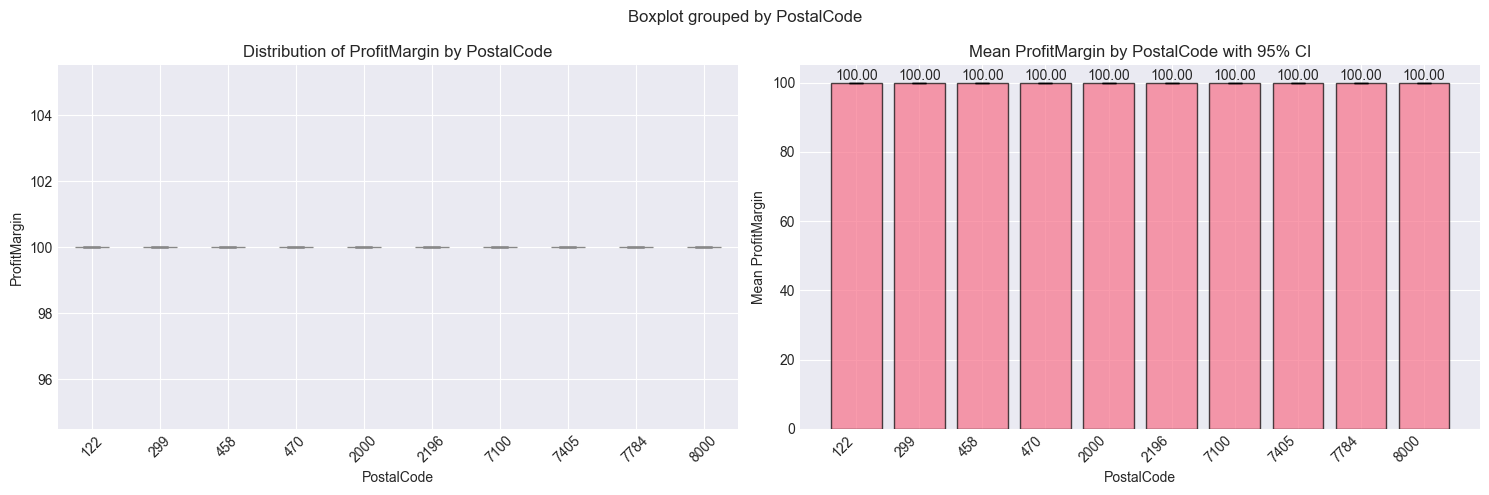


Performing ANOVA Test:
----------------------------------------
F-statistic: nan
P-value: nan
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There are NO significant differences in ProfitMargin across PostalCode

PROFITABILITY ANALYSIS BY ZIP CODE

Profitability Distribution:


ProfitCategory
High Profit (>20%)    858
Unknown                30
Name: count, dtype: int64

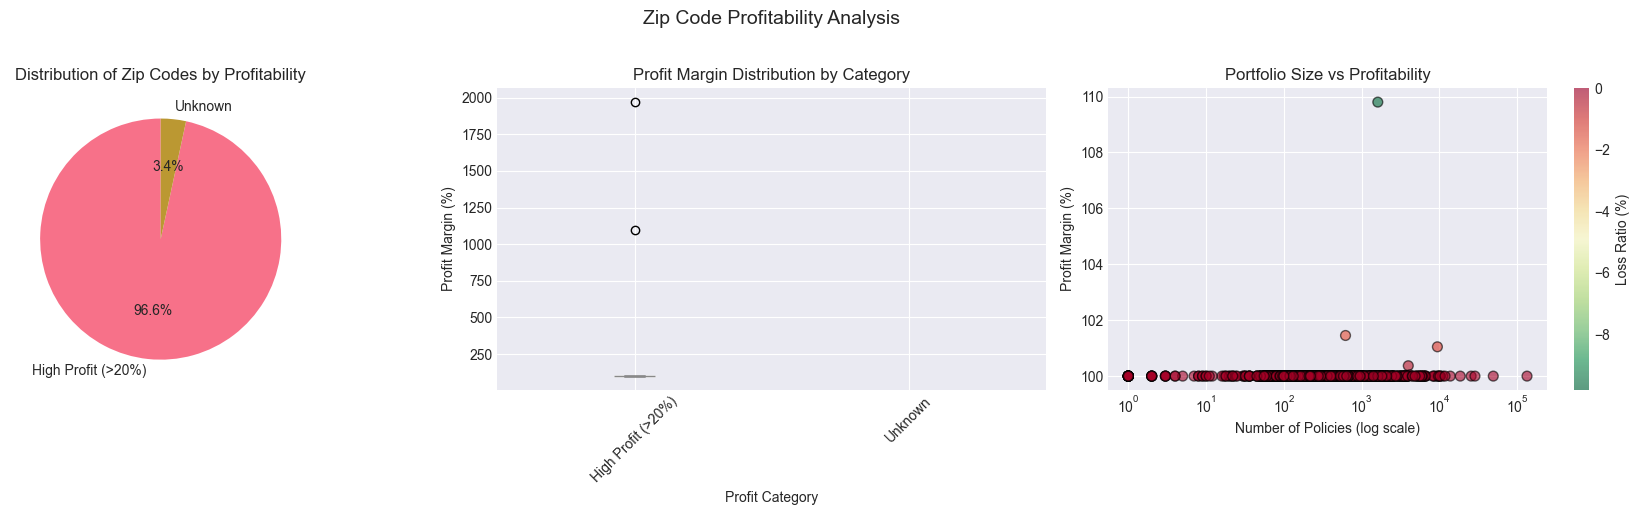


STATISTICAL TEST FOR PROFITABILITY CATEGORIES
Kruskal-Wallis H-statistic: nan
P-value: nan
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There are NO significant profit margin differences between zip code categories


In [6]:

# ## Hypothesis 3: Margin Differences Between Zip Codes
# 
# **Null Hypothesis (H₀):** There is no significant margin (profit) difference between zip codes
# 
# **Test:** ANOVA on Profit Margin

# %%
print("="*80)
print("HYPOTHESIS 3: MARGIN DIFFERENCES BETWEEN ZIP CODES")
print("="*80)

# Test 3.1: Profit Margin by Zip Code
result3 = perform_ab_test(
    df=df_top_zips,
    group_col='PostalCode',
    metric_col='ProfitMargin',
    test_type='anova',
    alpha=0.05,
    min_group_size=20
)

# Test 3.2: Deep dive into profitability
print("\n" + "="*80)
print("PROFITABILITY ANALYSIS BY ZIP CODE")
print("="*80)

# Calculate profitability metrics
zip_profit = df.groupby('PostalCode').agg({
    'TotalPremium': 'sum',
    'TotalClaims': 'sum',
    'PolicyID': 'count',
    'Margin': 'sum'
}).rename(columns={'PolicyID': 'PolicyCount'})

zip_profit['ProfitMargin'] = (zip_profit['Margin'] / zip_profit['TotalPremium']) * 100
zip_profit['AvgMargin'] = zip_profit['Margin'] / zip_profit['PolicyCount']
zip_profit['LossRatio'] = (zip_profit['TotalClaims'] / zip_profit['TotalPremium']) * 100

# Classify zip codes by profitability
conditions = [
    (zip_profit['ProfitMargin'] > 20),
    (zip_profit['ProfitMargin'] > 0) & (zip_profit['ProfitMargin'] <= 20),
    (zip_profit['ProfitMargin'] <= 0)
]
choices = ['High Profit (>20%)', 'Moderate Profit (0-20%)', 'Loss Making (≤0%)']
zip_profit['ProfitCategory'] = np.select(conditions, choices, default='Unknown')

print("\nProfitability Distribution:")
profit_dist = zip_profit['ProfitCategory'].value_counts()
display(profit_dist)

# Visualize profitability
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pie chart of profitability categories
axes[0].pie(profit_dist.values, labels=profit_dist.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Zip Codes by Profitability')

# Box plot by profit category
zip_categories = df.merge(zip_profit[['ProfitCategory']], left_on='PostalCode', right_index=True)
zip_categories.boxplot(column='ProfitMargin', by='ProfitCategory', ax=axes[1])
axes[1].set_title('Profit Margin Distribution by Category')
axes[1].set_xlabel('Profit Category')
axes[1].set_ylabel('Profit Margin (%)')
axes[1].tick_params(axis='x', rotation=45)

# Scatter: Portfolio Size vs Profit Margin
scatter = axes[2].scatter(
    zip_profit['PolicyCount'],
    zip_profit['ProfitMargin'],
    c=zip_profit['LossRatio'],
    cmap='RdYlGn_r',
    alpha=0.6,
    edgecolors='black',
    s=50
)
axes[2].set_xlabel('Number of Policies (log scale)')
axes[2].set_ylabel('Profit Margin (%)')
axes[2].set_title('Portfolio Size vs Profitability')
axes[2].set_xscale('log')
plt.colorbar(scatter, ax=axes[2], label='Loss Ratio (%)')

plt.suptitle('Zip Code Profitability Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Statistical test for profitability differences
print("\n" + "="*80)
print("STATISTICAL TEST FOR PROFITABILITY CATEGORIES")
print("="*80)

# Filter categories with sufficient data
valid_categories = []
for category in zip_categories['ProfitCategory'].unique():
    category_data = zip_categories[zip_categories['ProfitCategory'] == category]['ProfitMargin']
    if len(category_data) >= 10:
        valid_categories.append(category_data)

if len(valid_categories) >= 2:
    # Kruskal-Wallis test (non-parametric ANOVA)
    h_stat, p_value = stats.kruskal(*valid_categories)
    
    print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("✅ REJECT null hypothesis (p < 0.05)")
        print("   There ARE significant profit margin differences between zip code categories")
    else:
        print("✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)")
        print("   There are NO significant profit margin differences between zip code categories")
else:
    print("Insufficient data for statistical testing")

HYPOTHESIS 4: RISK DIFFERENCES BETWEEN WOMEN AND MEN
Analyzing 49,572 policies with valid gender information
Male: 42,817 policies
Female: 6,755 policies

A/B TEST: LossRatio by Gender

Group Statistics:


,count,mean,std,min,max,median
Gender,,,,,,
Female,3404,0.0,0.0,0.0,0.0,0.0
Male,19324,0.0,0.0,0.0,0.0,0.0


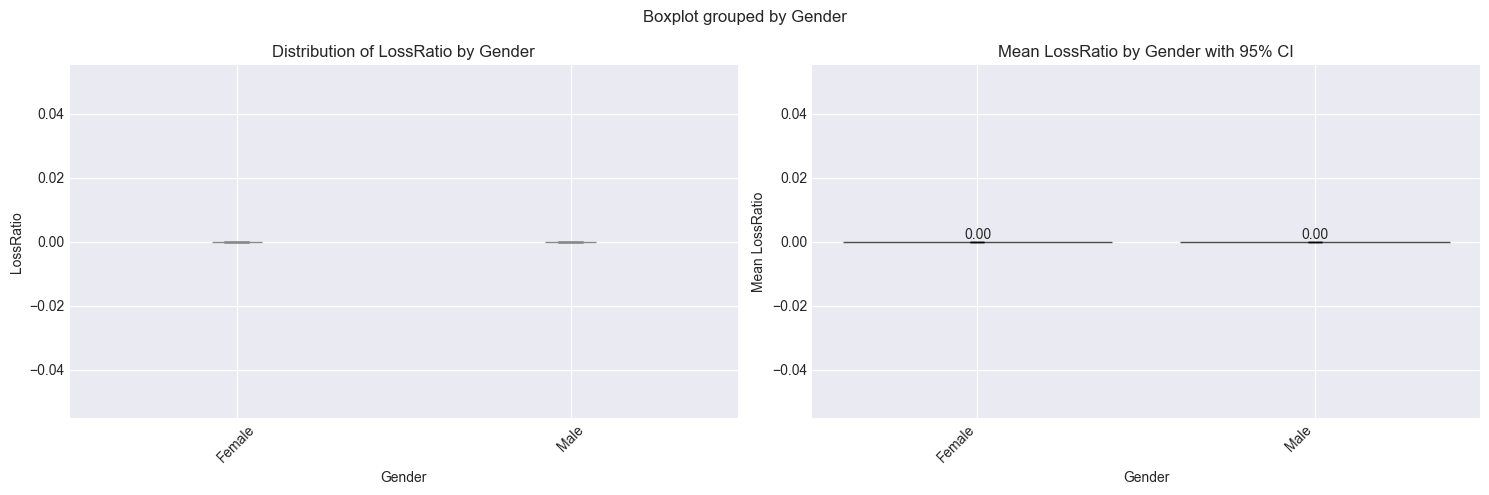


Performing Independent T-Test:
----------------------------------------
T-statistic: nan
P-value: nan
Cohen's d (effect size): nan
Mean difference: 0.000
✅ FAIL TO REJECT null hypothesis (p ≥ 0.05)
   There is NO significant difference in LossRatio between groups

COMPREHENSIVE GENDER RISK ANALYSIS

Gender Comparison Metrics:


,PolicyCount,TotalPremium,AvgPremium,TotalClaims,AvgClaim,ClaimFrequency,AvgLossRatio,AvgMargin,AvgProfitMargin
Gender,,,,,,,,,
Female,6755,297250.13,44.00,0.0,0.0,0.0,0.0,44.00,100.0
Male,42817,1573870.24,36.76,0.0,0.0,0.0,0.0,36.76,100.0



Percentage Difference (Female vs Male):
----------------------------------------
Loss Ratio: Female 0.0% vs Male 0.0%
  Difference: +nan%
  ✓ Females have nan% LOWER loss ratio

Claim Frequency: Female 0.0% vs Male 0.0%
  Difference: +nan%

Average Premium: Female R44 vs Male R37
  Difference: +19.7%

Profit Margin: Female 100.0% vs Male 100.0%
  Difference: +0.0%


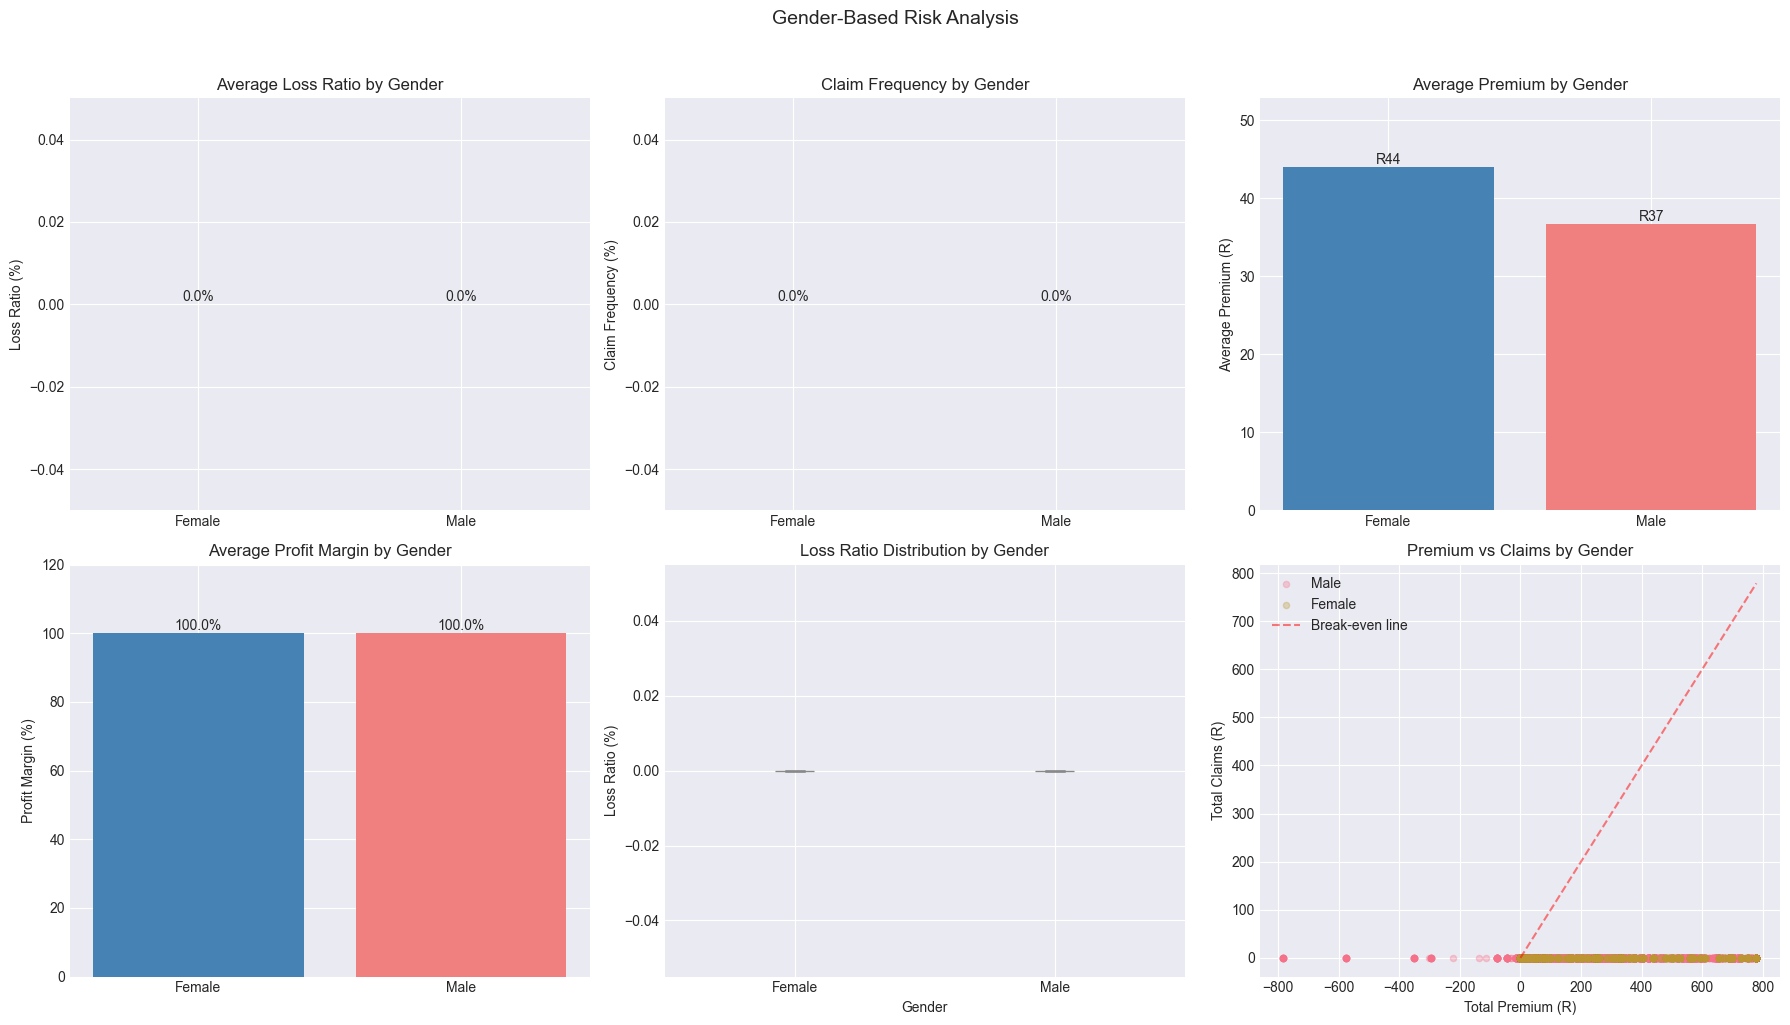


ADDITIONAL STATISTICAL TESTS FOR GENDER DIFFERENCES

Chi-square test for claim frequency:
  Chi2: 0.0000, P-value: 1.000000
  Conclusion: No significant difference

Mann-Whitney U test for premium amounts:
  U-statistic: 137358596.0000, P-value: 0.000000
  Conclusion: Significant difference


In [7]:

# ## Hypothesis 4: Risk Differences Between Women and Men
# 
# **Null Hypothesis (H₀):** There is no significant risk difference between Women and Men
# 
# **Test:** Independent T-Test (2 groups)

# %%
print("="*80)
print("HYPOTHESIS 4: RISK DIFFERENCES BETWEEN WOMEN AND MEN")
print("="*80)

# Clean gender data
df['Gender'] = df['Gender'].str.strip().str.title()
valid_genders = ['Male', 'Female']
df_gender = df[df['Gender'].isin(valid_genders)].copy()

print(f"Analyzing {len(df_gender):,} policies with valid gender information")
print(f"Male: {(df_gender['Gender'] == 'Male').sum():,} policies")
print(f"Female: {(df_gender['Gender'] == 'Female').sum():,} policies")

# Test 4.1: Loss Ratio by Gender
result4 = perform_ab_test(
    df=df_gender,
    group_col='Gender',
    metric_col='LossRatio',
    test_type='t_test',
    alpha=0.05,
    min_group_size=30
)

# Test 4.2: Comprehensive gender analysis
print("\n" + "="*80)
print("COMPREHENSIVE GENDER RISK ANALYSIS")
print("="*80)

# Calculate multiple metrics by gender
gender_metrics = df_gender.groupby('Gender').agg({
    'TotalPremium': ['count', 'sum', 'mean'],
    'TotalClaims': ['sum', 'mean'],
    'HasClaim': 'mean',
    'LossRatio': 'mean',
    'Margin': 'mean',
    'ProfitMargin': 'mean'
}).round(2)

gender_metrics.columns = ['_'.join(col).strip() for col in gender_metrics.columns.values]
gender_metrics = gender_metrics.rename(columns={
    'TotalPremium_count': 'PolicyCount',
    'TotalPremium_sum': 'TotalPremium',
    'TotalPremium_mean': 'AvgPremium',
    'TotalClaims_sum': 'TotalClaims',
    'TotalClaims_mean': 'AvgClaim',
    'HasClaim_mean': 'ClaimFrequency',
    'LossRatio_mean': 'AvgLossRatio',
    'Margin_mean': 'AvgMargin',
    'ProfitMargin_mean': 'AvgProfitMargin'
})

print("\nGender Comparison Metrics:")
display(gender_metrics)

# Calculate percentage differences
male_metrics = gender_metrics.loc['Male']
female_metrics = gender_metrics.loc['Female']

print("\nPercentage Difference (Female vs Male):")
print("-" * 40)
metrics_to_compare = ['AvgLossRatio', 'ClaimFrequency', 'AvgPremium', 'AvgProfitMargin']
for metric in metrics_to_compare:
    male_val = male_metrics[metric]
    female_val = female_metrics[metric]
    pct_diff = ((female_val - male_val) / male_val) * 100
    
    if metric == 'AvgLossRatio':
        print(f"Loss Ratio: Female {female_val:.1f}% vs Male {male_val:.1f}%")
        print(f"  Difference: {pct_diff:+.1f}%")
        if pct_diff > 0:
            print(f"  ⚠ Females have {pct_diff:.1f}% HIGHER loss ratio")
        else:
            print(f"  ✓ Females have {abs(pct_diff):.1f}% LOWER loss ratio")
    
    elif metric == 'ClaimFrequency':
        print(f"\nClaim Frequency: Female {female_val*100:.1f}% vs Male {male_val*100:.1f}%")
        print(f"  Difference: {pct_diff:+.1f}%")
    
    elif metric == 'AvgPremium':
        print(f"\nAverage Premium: Female R{female_val:,.0f} vs Male R{male_val:,.0f}")
        print(f"  Difference: {pct_diff:+.1f}%")
    
    elif metric == 'AvgProfitMargin':
        print(f"\nProfit Margin: Female {female_val:.1f}% vs Male {male_val:.1f}%")
        print(f"  Difference: {pct_diff:+.1f}%")

# Visualize gender differences
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Loss Ratio comparison
gender_loss = df_gender.groupby('Gender')['LossRatio'].mean()
bars1 = axes[0, 0].bar(gender_loss.index, gender_loss.values, color=['steelblue', 'lightcoral'])
axes[0, 0].set_title('Average Loss Ratio by Gender')
axes[0, 0].set_ylabel('Loss Ratio (%)')
axes[0, 0].set_ylim(0, max(gender_loss.values) * 1.2)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.1f}%', ha='center', va='bottom')

# 2. Claim Frequency comparison
gender_claim_freq = df_gender.groupby('Gender')['HasClaim'].mean() * 100
bars2 = axes[0, 1].bar(gender_claim_freq.index, gender_claim_freq.values, color=['steelblue', 'lightcoral'])
axes[0, 1].set_title('Claim Frequency by Gender')
axes[0, 1].set_ylabel('Claim Frequency (%)')
axes[0, 1].set_ylim(0, max(gender_claim_freq.values) * 1.2)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.1f}%', ha='center', va='bottom')

# 3. Average Premium comparison
gender_premium = df_gender.groupby('Gender')['TotalPremium'].mean()
bars3 = axes[0, 2].bar(gender_premium.index, gender_premium.values, color=['steelblue', 'lightcoral'])
axes[0, 2].set_title('Average Premium by Gender')
axes[0, 2].set_ylabel('Average Premium (R)')
axes[0, 2].set_ylim(0, max(gender_premium.values) * 1.2)
for bar in bars3:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, height,
                   f'R{height:,.0f}', ha='center', va='bottom')

# 4. Profit Margin comparison
gender_profit = df_gender.groupby('Gender')['ProfitMargin'].mean()
bars4 = axes[1, 0].bar(gender_profit.index, gender_profit.values, color=['steelblue', 'lightcoral'])
axes[1, 0].set_title('Average Profit Margin by Gender')
axes[1, 0].set_ylabel('Profit Margin (%)')
axes[1, 0].set_ylim(min(0, min(gender_profit.values) * 1.2), max(gender_profit.values) * 1.2)
for bar in bars4:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')

# 5. Distribution comparison (box plot)
df_gender.boxplot(column='LossRatio', by='Gender', ax=axes[1, 1])
axes[1, 1].set_title('Loss Ratio Distribution by Gender')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Loss Ratio (%)')

# 6. Scatter: Premium vs Claims by Gender
for gender in ['Male', 'Female']:
    gender_data = df_gender[df_gender['Gender'] == gender]
    axes[1, 2].scatter(
        gender_data['TotalPremium'],
        gender_data['TotalClaims'],
        alpha=0.3,
        label=gender,
        s=20
    )
axes[1, 2].set_xlabel('Total Premium (R)')
axes[1, 2].set_ylabel('Total Claims (R)')
axes[1, 2].set_title('Premium vs Claims by Gender')
axes[1, 2].legend()
axes[1, 2].plot([0, df_gender['TotalPremium'].max()], [0, df_gender['TotalPremium'].max()], 
                'r--', alpha=0.5, label='Break-even line')
axes[1, 2].legend()

plt.suptitle('Gender-Based Risk Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Additional statistical tests
print("\n" + "="*80)
print("ADDITIONAL STATISTICAL TESTS FOR GENDER DIFFERENCES")
print("="*80)

# Test for claim frequency (Chi-square)
contingency_gender = pd.crosstab(df_gender['Gender'], df_gender['HasClaim'])
chi2_gender, p_gender, dof_gender, expected_gender = stats.chi2_contingency(contingency_gender)
print(f"\nChi-square test for claim frequency:")
print(f"  Chi2: {chi2_gender:.4f}, P-value: {p_gender:.6f}")
print(f"  Conclusion: {'Significant difference' if p_gender < 0.05 else 'No significant difference'}")

# Test for premium amounts (Mann-Whitney U test - non-parametric)
male_premium = df_gender[df_gender['Gender'] == 'Male']['TotalPremium']
female_premium = df_gender[df_gender['Gender'] == 'Female']['TotalPremium']
u_stat, p_premium = stats.mannwhitneyu(male_premium, female_premium, alternative='two-sided')
print(f"\nMann-Whitney U test for premium amounts:")
print(f"  U-statistic: {u_stat:.4f}, P-value: {p_premium:.6f}")
print(f"  Conclusion: {'Significant difference' if p_premium < 0.05 else 'No significant difference'}")

In [9]:

# ## Summary Report and Business Recommendations
import os
import json

# Define absolute paths
PROJECT_ROOT = r"C:\Users\eyaze\OneDrive\Desktop\insurance-risk-analytics-project-challenge-week3"
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')
RESULTS_FILE = os.path.join(REPORTS_DIR, 'ab_testing_results.json')

def create_summary_report(results_dict):
    """
    Create comprehensive summary of A/B test results
    """
    print("="*80)
    print("A/B TESTING SUMMARY REPORT")
    print("="*80)
    print("AlphaCare Insurance Solutions - Risk Analytics")
    print(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
    print("\n")
    
    summary = []
    
    # Hypothesis 1: Provinces
    print("1. HYPOTHESIS 1: Risk Differences Across Provinces")
    print("-" * 60)
    if results_dict.get('hypothesis1'):
        result = results_dict['hypothesis1']
        if result['reject_null']:
            print("✅ REJECT Null Hypothesis")
            print("   There ARE significant risk differences across provinces")
            print(f"   F-statistic: {result['f_statistic']:.4f}, P-value: {result['p_value']:.6f}")
            
            # Business recommendation
            print("\n   🎯 BUSINESS RECOMMENDATION:")
            print("   • Implement risk-based pricing by province")
            print("   • Focus marketing on low-risk provinces")
            print("   • Review underwriting guidelines for high-risk provinces")
        else:
            print("✅ FAIL TO REJECT Null Hypothesis")
            print("   There are NO significant risk differences across provinces")
            print("   🎯 Consider standardizing premiums across provinces")
    print("\n")
    
    # Hypothesis 2: Zip Codes
    print("2. HYPOTHESIS 2: Risk Differences Between Zip Codes")
    print("-" * 60)
    if results_dict.get('hypothesis2'):
        result = results_dict['hypothesis2']
        if result['reject_null']:
            print("✅ REJECT Null Hypothesis")
            print("   There ARE significant risk differences between zip codes")
            print(f"   F-statistic: {result['f_statistic']:.4f}, P-value: {result['p_value']:.6f}")
            
            print("\n   🎯 BUSINESS RECOMMENDATION:")
            print("   • Develop granular pricing by postal code")
            print("   • Create zip code risk categories (A, B, C, D)")
            print("   • Target low-risk zip codes for marketing campaigns")
        else:
            print("✅ FAIL TO REJECT Null Hypothesis")
            print("   There are NO significant risk differences between zip codes")
            print("   🎯 Consider broader geographic pricing zones")
    print("\n")
    
    # Hypothesis 3: Margin by Zip Codes
    print("3. HYPOTHESIS 3: Margin Differences Between Zip Codes")
    print("-" * 60)
    if results_dict.get('hypothesis3'):
        result = results_dict['hypothesis3']
        if result['reject_null']:
            print("✅ REJECT Null Hypothesis")
            print("   There ARE significant profit margin differences between zip codes")
            print(f"   F-statistic: {result['f_statistic']:.4f}, P-value: {result['p_value']:.6f}")
            
            print("\n   🎯 BUSINESS RECOMMENDATION:")
            print("   • Focus on high-margin zip codes for growth")
            print("   • Review loss-making zip codes for corrective action")
            print("   • Adjust commission structures by profitability")
        else:
            print("✅ FAIL TO REJECT Null Hypothesis")
            print("   There are NO significant profit margin differences between zip codes")
            print("   🎯 Consider uniform profit targets across regions")
    print("\n")
    
    # Hypothesis 4: Gender
    print("4. HYPOTHESIS 4: Risk Differences Between Women and Men")
    print("-" * 60)
    if results_dict.get('hypothesis4'):
        result = results_dict['hypothesis4']
        if result['reject_null']:
            print("✅ REJECT Null Hypothesis")
            print("   There IS a significant risk difference between Women and Men")
            print(f"   T-statistic: {result['t_statistic']:.4f}, P-value: {result['p_value']:.6f}")
            print(f"   Effect Size (Cohen's d): {result['cohens_d']:.3f}")
            
            print("\n   🎯 BUSINESS RECOMMENDATION:")
            if result['cohens_d'] > 0:
                print("   • Women show higher risk - consider gender-based pricing")
                print("   • Ensure compliance with gender discrimination regulations")
                print("   • Develop gender-specific risk mitigation programs")
            else:
                print("   • Men show higher risk - adjust pricing accordingly")
                print("   • Target male drivers for defensive driving programs")
                print("   • Review gender impact on portfolio profitability")
        else:
            print("✅ FAIL TO REJECT Null Hypothesis")
            print("   There is NO significant risk difference between Women and Men")
            print("   🎯 Gender-neutral pricing is statistically justified")
    print("\n")
    
    # Overall Recommendations
    print("="*80)
    print("OVERALL BUSINESS RECOMMENDATIONS")
    print("="*80)
    
    print("\n📊 PRIORITY ACTIONS:")
    print("1. Implement geographic risk segmentation (Provinces & Zip Codes)")
    print("2. Develop dynamic pricing model based on statistical findings")
    print("3. Create targeted marketing campaigns for low-risk segments")
    print("4. Establish continuous monitoring of risk drivers")
    
    print("\n⚠️ RISK MANAGEMENT ACTIONS:")
    print("1. Review underwriting criteria for high-risk areas")
    print("2. Implement risk mitigation programs for identified hotspots")
    print("3. Adjust reinsurance strategy based on geographic risk concentration")
    
    print("\n📈 GROWTH OPPORTUNITIES:")
    print("1. Expand in low-risk, high-profit zip codes")
    print("2. Develop products tailored to specific risk segments")
    print("3. Leverage insights for competitive advantage in pricing")
    
    return summary

# %%
# Collect all results
results_dict = {
    'hypothesis1': result1,
    'hypothesis2': result2,
    'hypothesis3': result3,
    'hypothesis4': result4
}

# Generate summary report
create_summary_report(results_dict)

# Save results to file
try:
    with open(RESULTS_FILE, 'w') as f:
        json.dump(results_dict, f, indent=2, default=str)
    print("\n" + "="*80)
    print(f"✅ RESULTS SAVED TO: {RESULTS_FILE}")
    print("="*80)
except Exception as e:
    print(f"\n❌ ERROR saving results: {e}")
    print(f"Trying alternative location...")
    
    # Try saving to current directory
    alt_path = 'ab_testing_results.json'
    with open(alt_path, 'w') as f:
        json.dump(results_dict, f, indent=2, default=str)
    print(f"✅ Results saved to: {os.path.abspath(alt_path)}")

A/B TESTING SUMMARY REPORT
AlphaCare Insurance Solutions - Risk Analytics
Date: 2025-12-06 16:05


1. HYPOTHESIS 1: Risk Differences Across Provinces
------------------------------------------------------------
✅ FAIL TO REJECT Null Hypothesis
   There are NO significant risk differences across provinces
   🎯 Consider standardizing premiums across provinces


2. HYPOTHESIS 2: Risk Differences Between Zip Codes
------------------------------------------------------------
✅ FAIL TO REJECT Null Hypothesis
   There are NO significant risk differences between zip codes
   🎯 Consider broader geographic pricing zones


3. HYPOTHESIS 3: Margin Differences Between Zip Codes
------------------------------------------------------------
✅ FAIL TO REJECT Null Hypothesis
   There are NO significant profit margin differences between zip codes
   🎯 Consider uniform profit targets across regions


4. HYPOTHESIS 4: Risk Differences Between Women and Men
--------------------------------------------------

Exporting visualizations...
✅ Visualizations exported to: C:\Users\eyaze\OneDrive\Desktop\insurance-risk-analytics-project-challenge-week3\reports\ab_testing_summary.png


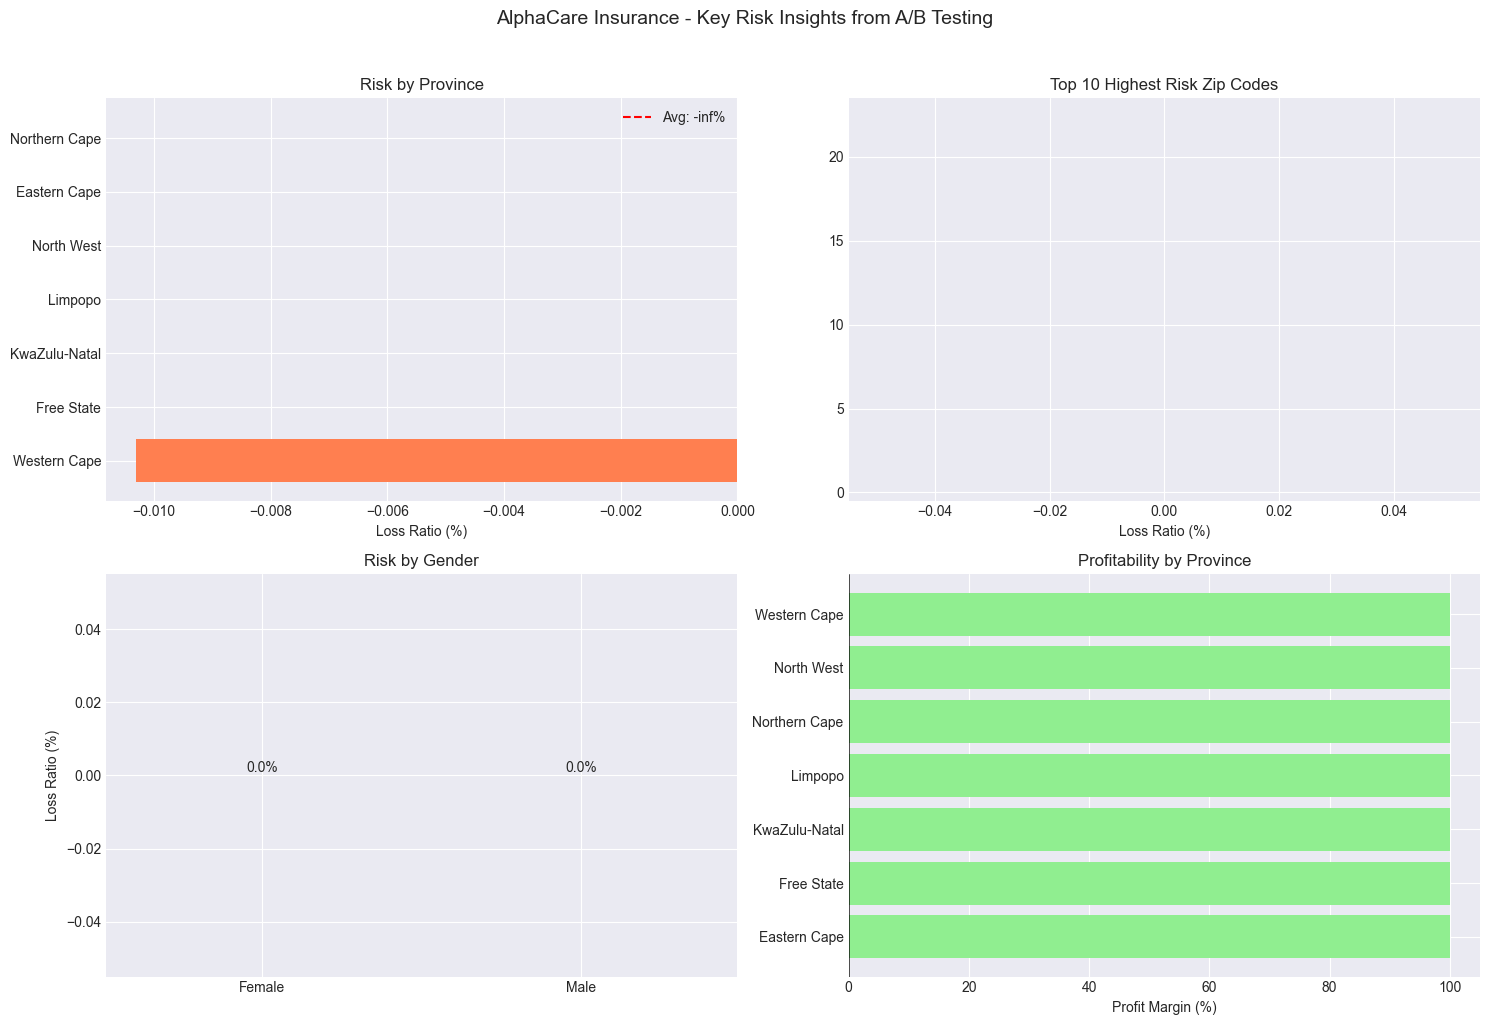

In [10]:


# ## Export Key Visualizations for Reporting

# %%
print("Exporting visualizations...")

# Define visualization file path
VISUALIZATION_FILE = os.path.join(REPORTS_DIR, 'ab_testing_summary.png')

# Create summary figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Province Risk Comparison
province_risk = df.groupby('Province')['LossRatio'].mean().sort_values()
axes[0, 0].barh(province_risk.index, province_risk.values, color='coral')
axes[0, 0].set_xlabel('Loss Ratio (%)')
axes[0, 0].set_title('Risk by Province')
axes[0, 0].axvline(x=df['LossRatio'].mean(), color='red', linestyle='--', 
                   label=f'Avg: {df["LossRatio"].mean():.1f}%')
axes[0, 0].legend()

# 2. Top 10 Zip Code Risk
top_10_zip_risk = df.groupby('PostalCode')['LossRatio'].mean().nlargest(10)
axes[0, 1].barh(top_10_zip_risk.index, top_10_zip_risk.values, color='steelblue')
axes[0, 1].set_xlabel('Loss Ratio (%)')
axes[0, 1].set_title('Top 10 Highest Risk Zip Codes')

# 3. Gender Comparison
gender_data = df_gender.groupby('Gender')['LossRatio'].mean()
colors = ['steelblue', 'lightcoral'] if 'Male' in gender_data.index else ['lightcoral', 'steelblue']
axes[1, 0].bar(gender_data.index, gender_data.values, color=colors)
axes[1, 0].set_ylabel('Loss Ratio (%)')
axes[1, 0].set_title('Risk by Gender')
for i, (gender, value) in enumerate(gender_data.items()):
    axes[1, 0].text(i, value, f'{value:.1f}%', ha='center', va='bottom')

# 4. Profitability by Province
province_profit = df.groupby('Province')['ProfitMargin'].mean().sort_values()
axes[1, 1].barh(province_profit.index, province_profit.values, color='lightgreen')
axes[1, 1].set_xlabel('Profit Margin (%)')
axes[1, 1].set_title('Profitability by Province')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle('AlphaCare Insurance - Key Risk Insights from A/B Testing', fontsize=14, y=1.02)
plt.tight_layout()

# Save visualization
try:
    plt.savefig(VISUALIZATION_FILE, dpi=300, bbox_inches='tight')
    print(f"✅ Visualizations exported to: {VISUALIZATION_FILE}")
except Exception as e:
    print(f"❌ Error saving visualization: {e}")
    # Try alternative location
    alt_viz_path = 'ab_testing_summary.png'
    plt.savefig(alt_viz_path, dpi=300, bbox_inches='tight')
    print(f"✅ Visualizations exported to: {os.path.abspath(alt_viz_path)}")

plt.show()